### IMPORT LIBRERIE

In [10]:
# --- 1. IMPORT LIBRERIE ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, 
    classification_report, 
    confusion_matrix, 
    ConfusionMatrixDisplay
)
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

pd.set_option('display.max_columns', None)
print("Librerie importate con successo.")

Librerie importate con successo.


### CARICAMENTO DEI DATI

In [11]:
# --- 2. CARICAMENTO DEI DATI ---

file_path = '../data/puliti/movimento_fe.csv'
try:
    df = pd.read_csv(file_path)
    df_ml = df.copy()
    print(f"Dati caricati con successo da {file_path}.")
    display(df_ml.head())
except FileNotFoundError:
    print(f"Errore: Il file {file_path} non è stato trovato.")

Dati caricati con successo da ../data/puliti/movimento_fe.csv.


,Name,OVR,PAC,SHO,PAS,DRI,DEF,PHY,Acceleration,Sprint Speed,Positioning,Finishing,Shot Power,Long Shots,Volleys,Penalties,Vision,Crossing,Free Kick Accuracy,Short Passing,Long Passing,Curve,Dribbling,Agility,Balance,Reactions,Ball Control,Composure,Interceptions,Heading Accuracy,Def Awareness,Standing Tackle,Sliding Tackle,Jumping,Stamina,Strength,Aggression,Position,Weak foot,Skill moves,Preferred foot,Height,Weight,Alternative positions,Age,Nation,League,Team,play style,num_alt_pos_att,num_alt_pos_cen,num_alt_pos_dif,ps_scoring,ps_scoring_plus,ps_passing,ps_passing_plus,ps_control,ps_control_plus,ps_defend,ps_defend_plus,ps_physical,ps_physical_plus
0,Kylian Mbappé,91,97,90,80,92,36,78,97,97,93,94,90,83,84,84,83,78,69,86,71,80,93,93,82,93,92,88,38,73,26,34,32,88,88,77,64,ST,4,5,Right,"182cm / 6'0""",75kg / 165lb,LW,25,France,LALIGA EA SPORTS,Real Madrid,"Quick Step+, Acrobatic, Finesse Shot, Flair, R...",1,0,0,1,0,0,0,1,0,0,0,2,1
1,Rodri,91,66,80,86,84,87,85,65,66,76,74,92,89,71,62,84,76,64,93,91,86,84,66,67,93,90,94,84,81,92,87,82,83,91,83,85,CDM,4,3,Right,"191cm / 6'3""",82kg / 181lb,CM,28,Spain,Premier League,Manchester City,"Tiki Taka+, Aerial, Bruiser, Long Ball Pass, P...",0,1,0,1,0,1,1,1,0,1,0,1,0
2,Erling Haaland,91,88,92,70,81,45,88,80,94,96,96,94,83,90,90,74,58,62,77,66,77,79,77,69,94,83,87,43,83,38,47,29,92,76,93,88,ST,3,3,Left,"195cm / 6'5""",94kg / 207lb,NaN,24,Norway,Premier League,Manchester City,"Acrobatic+, Bruiser, Power Header, Power Shot,...",0,0,0,2,0,0,0,1,0,1,0,0,1
3,Jude Bellingham,90,80,87,83,88,78,83,81,80,91,90,85,86,77,74,90,66,68,89,89,73,89,82,79,91,89,87,82,75,77,79,77,84,93,77,85,CAM,4,4,Right,"186cm / 6'1""",75kg / 165lb,CM,21,England,LALIGA EA SPORTS,Real Madrid,"Relentless+, Flair, Intercept, Slide Tackle, T...",0,1,0,0,0,0,0,2,0,2,0,0,1
4,Vini Jr.,90,95,84,81,91,29,69,95,95,87,89,81,83,73,71,85,81,62,83,77,79,93,94,84,86,90,83,26,50,32,25,18,74,84,65,58,LW,4,5,Right,"176cm / 5'9""",73kg / 161lb,"ST, LM",24,Brazil,LALIGA EA SPORTS,Real Madrid,"Quick Step+, Chip Shot, Finesse Shot, First To...",1,1,0,2,0,0,0,2,0,0,0,1,1


### CREAZIONE VARIABILI TARGET (y)

In [12]:
# --- 3. CREAZIONE VARIABILI TARGET (y) ---
print("Creazione della colonna target 'top_player'...")

# Definizione della soglia per i top player
SOGLIA_TOP_PLAYER = 86

# 1 = Top Player, 0 = Non Top Player
df_ml['is_top_player'] = (df_ml['OVR'] >= SOGLIA_TOP_PLAYER).astype(int)

print("Colonna 'is_top_player' creata con successo.")

# Verifica
print("\nVerifica creazione colonna target:")
display(df_ml[['Name','OVR', 'is_top_player']].sort_values(by='OVR', ascending=False).head(10))
display(df_ml['is_top_player'].value_counts(normalize=True)*100)

Creazione della colonna target 'top_player'...
Colonna 'is_top_player' creata con successo.

Verifica creazione colonna target:


,Name,OVR,is_top_player
0,Kylian Mbappé,91,1
14345,Aitana Bonmatí,91,1
2,Erling Haaland,91,1
1,Rodri,91,1
14347,Caroline Graham Hansen,90,1
14348,Sam Kerr,90,1
14346,Alexia Putellas,90,1
4,Vini Jr.,90,1
3,Jude Bellingham,90,1
5,Kevin De Bruyne,90,1


is_top_player
0    99.453552
1     0.546448
Name: proportion, dtype: float64

### 4. Analisi della Soglia: Dati Sbilanciati

Come si vede dalla Cella 3, usare una soglia di `OVR >= 86` produce un dataset **estremamente sbilanciato**: solo lo 0.54% dei giocatori è etichettato come "Top Player".

Un modello addestrato su questi dati imparerebbe solo a predire "0" (Non Top) e otterrebbe un'accuratezza fittizia del 99.46%, pur essendo completamente inutile.

**Decisione:** Dobbiamo trovare una soglia più ragionevole. Usiamo il metodo dei quantili per trovare quale `OVR` definisce, ad esempio, il **Top 15%** dei giocatori.

In [13]:
# --- 5. TROVIAMO NUOVA SOGLIA CON QUANTILE ---

# Troviamo l'ovr che definisce il top 10%
soglia_top_10 = df_ml['OVR'].quantile(0.90)

# Troviamo l'ovr che definisce il top 15%
soglia_top_15 = df_ml['OVR'].quantile(0.85)

print(f"Soglia per il top 10%: {soglia_top_10}")
print(f"Soglia per il top 15%: {soglia_top_15}")

Soglia per il top 10%: 76.0
Soglia per il top 15%: 74.0


In [14]:
# --- 6. Applichiamo la nuova soglia ---
print("Aggiornamento della colonna target 'is_top_player' con nuova soglia...")

# Inserisci la nuova soglia desiderata qui
NUOVA_SOGLIA = 74.0

# Sovrascrivi la colonna target con la nuova soglia
df_ml['is_top_player'] = (df_ml['OVR'] >= NUOVA_SOGLIA).astype(int)

print(f"Colonna Target 'is_top_player' (OVR >= {NUOVA_SOGLIA}) sovrascritta.")

# Verifica
print("\nVerifica aggiornamento colonna target:")
display(df_ml[['Name','OVR', 'is_top_player']].sort_values(by='OVR', ascending=False).head(10))
display(df_ml['is_top_player'].value_counts(normalize=True)*100)


Aggiornamento della colonna target 'is_top_player' con nuova soglia...
Colonna Target 'is_top_player' (OVR >= 74.0) sovrascritta.

Verifica aggiornamento colonna target:


,Name,OVR,is_top_player
0,Kylian Mbappé,91,1
14345,Aitana Bonmatí,91,1
2,Erling Haaland,91,1
1,Rodri,91,1
14347,Caroline Graham Hansen,90,1
14348,Sam Kerr,90,1
14346,Alexia Putellas,90,1
4,Vini Jr.,90,1
3,Jude Bellingham,90,1
5,Kevin De Bruyne,90,1


is_top_player
0    83.504893
1    16.495107
Name: proportion, dtype: float64

### ENCODING FINALE DELLE FEATURES (X)

In [15]:
# --- 7. ENCODING FEATURES (X) ---
print("Inizio encoding delle features...")

# Preferred Foot -> 0 = Right, 1 = Left
try:
    df_ml['is_left_footed'] = (df_ml['Preferred foot'] == 'Left').astype(int)
    print("Colonna 'is_left_footed' creata con successo.")
except KeyError:
    print("Errore: La colonna 'Preferred foot' non è presente nel DataFrame.")


Inizio encoding delle features...
Colonna 'is_left_footed' creata con successo.


### PULIZIA FINALE

In [16]:
# --- 8. PULIZIA FINALE (DROP COLONNE NON NUMERICHE) ---

print("Inizio pulizia finale colonne...")

colonne_da_rimuovere = [
    'OVR',                  # Rimuoviamo l'OVR per evitare data leakage
    'Preferred foot',       # LA STRINGA (il target numerico 'is_left_footed' rimane)
    'Alternative positions',
    'Height',
    'Weight',
    
    # Altro testo inutile per questo task
    'Position',
    'play style',
    'Work rates',           # Rimuoviamo anche se non c'è, per sicurezza
    
    # Identificatori
    'Name', 
    'Known As',
    'Player ID',
    'Full Name',
    'Age',
    'Nation',
    'League',
    'Team'
]

colonne_esist_da_rimuovere = [col for col in colonne_da_rimuovere if col in df_ml.columns]
print(f"Rimozione delle seguenti colonne: {colonne_esist_da_rimuovere}")

df_ml = df_ml.drop(columns=colonne_esist_da_rimuovere)
print("Pulizia completata.")

Inizio pulizia finale colonne...
Rimozione delle seguenti colonne: ['OVR', 'Preferred foot', 'Alternative positions', 'Height', 'Weight', 'Position', 'play style', 'Name', 'Age', 'Nation', 'League', 'Team']
Pulizia completata.


### VERIFICA FINALE 

In [17]:
# --- 9. VERIFICA FINALE  ---
print("Verifica finale del DataFrame:")
df_ml.info()

print("\nHead del DataFrame dopo tutte le trasformazioni:")
display(df_ml.head())

Verifica finale del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15738 entries, 0 to 15737
Data columns (total 52 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   PAC                 15738 non-null  int64
 1   SHO                 15738 non-null  int64
 2   PAS                 15738 non-null  int64
 3   DRI                 15738 non-null  int64
 4   DEF                 15738 non-null  int64
 5   PHY                 15738 non-null  int64
 6   Acceleration        15738 non-null  int64
 7   Sprint Speed        15738 non-null  int64
 8   Positioning         15738 non-null  int64
 9   Finishing           15738 non-null  int64
 10  Shot Power          15738 non-null  int64
 11  Long Shots          15738 non-null  int64
 12  Volleys             15738 non-null  int64
 13  Penalties           15738 non-null  int64
 14  Vision              15738 non-null  int64
 15  Crossing            15738 non-null  int64
 16  Free Kick

,PAC,SHO,PAS,DRI,DEF,PHY,Acceleration,Sprint Speed,Positioning,Finishing,Shot Power,Long Shots,Volleys,Penalties,Vision,Crossing,Free Kick Accuracy,Short Passing,Long Passing,Curve,Dribbling,Agility,Balance,Reactions,Ball Control,Composure,Interceptions,Heading Accuracy,Def Awareness,Standing Tackle,Sliding Tackle,Jumping,Stamina,Strength,Aggression,Weak foot,Skill moves,num_alt_pos_att,num_alt_pos_cen,num_alt_pos_dif,ps_scoring,ps_scoring_plus,ps_passing,ps_passing_plus,ps_control,ps_control_plus,ps_defend,ps_defend_plus,ps_physical,ps_physical_plus,is_top_player,is_left_footed
0,97,90,80,92,36,78,97,97,93,94,90,83,84,84,83,78,69,86,71,80,93,93,82,93,92,88,38,73,26,34,32,88,88,77,64,4,5,1,0,0,1,0,0,0,1,0,0,0,2,1,1,0
1,66,80,86,84,87,85,65,66,76,74,92,89,71,62,84,76,64,93,91,86,84,66,67,93,90,94,84,81,92,87,82,83,91,83,85,4,3,0,1,0,1,0,1,1,1,0,1,0,1,0,1,0
2,88,92,70,81,45,88,80,94,96,96,94,83,90,90,74,58,62,77,66,77,79,77,69,94,83,87,43,83,38,47,29,92,76,93,88,3,3,0,0,0,2,0,0,0,1,0,1,0,0,1,1,1
3,80,87,83,88,78,83,81,80,91,90,85,86,77,74,90,66,68,89,89,73,89,82,79,91,89,87,82,75,77,79,77,84,93,77,85,4,4,0,1,0,0,0,0,0,2,0,2,0,0,1,1,0
4,95,84,81,91,29,69,95,95,87,89,81,83,73,71,85,81,62,83,77,79,93,94,84,86,90,83,26,50,32,25,18,74,84,65,58,4,5,1,1,0,2,0,0,0,2,0,0,0,1,1,1,0


### DEFINIZIONE DI X (FEATURES) E Y (TARGET) 

In [18]:
# --- 10. DEFINIZIONE DI X (FEATURES) E Y (TARGET) ---

TASK_TARGET = 'is_top_player'
print(f"Target per il task di classificazione: '{TASK_TARGET}'")

# Definiamo il target
y = df_ml[TASK_TARGET]

# Definiamo le features
X = df_ml.drop(columns=[TASK_TARGET])

# Verifica
print(f"Forma delle features X: {X.shape}")
print(f"Forma del target y: {y.shape}")
print(f"\nColonne in X: {list(X.columns)}")

Target per il task di classificazione: 'is_top_player'
Forma delle features X: (15738, 51)
Forma del target y: (15738,)

Colonne in X: ['PAC', 'SHO', 'PAS', 'DRI', 'DEF', 'PHY', 'Acceleration', 'Sprint Speed', 'Positioning', 'Finishing', 'Shot Power', 'Long Shots', 'Volleys', 'Penalties', 'Vision', 'Crossing', 'Free Kick Accuracy', 'Short Passing', 'Long Passing', 'Curve', 'Dribbling', 'Agility', 'Balance', 'Reactions', 'Ball Control', 'Composure', 'Interceptions', 'Heading Accuracy', 'Def Awareness', 'Standing Tackle', 'Sliding Tackle', 'Jumping', 'Stamina', 'Strength', 'Aggression', 'Weak foot', 'Skill moves', 'num_alt_pos_att', 'num_alt_pos_cen', 'num_alt_pos_dif', 'ps_scoring', 'ps_scoring_plus', 'ps_passing', 'ps_passing_plus', 'ps_control', 'ps_control_plus', 'ps_defend', 'ps_defend_plus', 'ps_physical', 'ps_physical_plus', 'is_left_footed']


### TRAIN-TEST SPLIT 

In [19]:
# --- 11. TRAIN-TEST SPLIT ---

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state=42,
                                                    stratify=y)

print(f"Dimensioni X_train: {X_train.shape}")
print(f"Dimensioni X_test: {X_test.shape}")
print(f"\nDistribuzione 'is_top_player' nel training set:")
display(y_train.value_counts(normalize=True)*100)

Dimensioni X_train: (11016, 51)
Dimensioni X_test: (4722, 51)

Distribuzione 'is_top_player' nel training set:


is_top_player
0    83.50581
1    16.49419
Name: proportion, dtype: float64

### SCALING DELLE FEATURES 

In [20]:
# --- 12. SCALING DELLE FEATURES ---
print("Inizio scaling delle features...")
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Scaling completato.")

Inizio scaling delle features...
Scaling completato.


### ADDESTRAMENTO MODELLO (LOGISTIC REGRESSION)

In [21]:
# --- 13. ADDESTRAMENTO MODELLO (LOGISTIC REGRESSION) ---
print("Inizio addestramento del modello Logistic Regression...")

# Usiamo class_weight='balanced' per bilanciare le classi
lr_top = LogisticRegression(
    max_iter=1000,
    random_state=42,
    class_weight='balanced'
)

lr_top.fit(X_train_scaled, y_train)
print("Modello addestrato con successo.")

Inizio addestramento del modello Logistic Regression...
Modello addestrato con successo.


### VALUTAZIONE DEL MODELLO 

Inizio valutazione del modello...
Accuracy del modello: 93.60%

Classification Report:
                    precision    recall  f1-score   support

NON TOP PLAYER (0)       0.99      0.94      0.96      3943
    TOP PLAYER (1)       0.75      0.93      0.83       779

          accuracy                           0.94      4722
         macro avg       0.87      0.93      0.89      4722
      weighted avg       0.95      0.94      0.94      4722

Confusion Matrix:


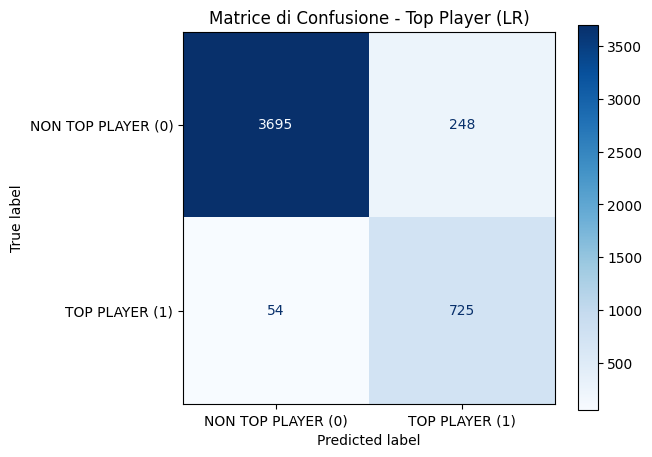

In [22]:
# --- 14. VALUTAZIONE DEL MODELLO ---

print("Inizio valutazione del modello...")
y_pred = lr_top.predict(X_test_scaled)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy del modello: {acc * 100:.2f}%")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['NON TOP PLAYER (0)', 'TOP PLAYER (1)']))

# Confusion Matrix
print("Confusion Matrix:")

cm = confusion_matrix(y_test, y_pred, labels=lr_top.classes_)
fig, ax = plt.subplots(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['NON TOP PLAYER (0)', 'TOP PLAYER (1)'])
disp.plot(cmap='Blues', ax=ax, xticks_rotation='horizontal')
plt.title("Matrice di Confusione - Top Player (LR)")
plt.show()

---
# ESPERIMENTO B: Valutare l'impatto della Posizione Principale
---

**Obiettivo:** Confrontare il modello precedente (Esperimento A) con un nuovo modello (Esperimento B).

* **Modello A:** Usava solo le 3 colonne `num_alt_pos_...`
* **Modello B:** Userà il One-Hot Encoding sulla colonna `Position` principale (creando ~16 nuove colonne) e le 3 `num_alt_pos_...`

**Ipotesi:** Dare al modello l'informazione esplicita della posizione principale (es. "questo è un CB") ridurrà i Falsi Positivi (i "raccomandati") e aumenterà l'accuratezza.

In [24]:
# --- 16. SETUP ESPERIMENTO B ---

# 1. Ricarichiamo i dati in un NUOVO DataFrame
print("Caricamento dati per Esperimento B...")
df_B = pd.read_csv('../data/puliti/movimento_fe.csv')

# 2. Creiamo il Target (con la soglia 74)
print("Creazione Target (OVR >= 74)...")
SOGLIA_CORRETTA = 74 
df_B['is_top_player'] = (df_B['OVR'] >= SOGLIA_CORRETTA).astype(int)

# 3. Creiamo le feature codificate (piede)
print("Encoding 'is_left_footed'...")
try:
    df_B['is_left_footed'] = (df_B['Preferred foot'] == 'Left').astype(int)
except KeyError:
    print("ERRORE: Colonna 'Preferred foot' non trovata.")

print("Setup B completato.")

Caricamento dati per Esperimento B...
Creazione Target (OVR >= 74)...
Encoding 'is_left_footed'...
Setup B completato.


In [25]:
# --- 17. PULIZIA FINALE (Esperimento B) ---
print("Inizio pulizia finale (Esperimento B: teniamo 'Position')...")

colonne_da_rimuovere_B = [
    # 1. IL DATA LEAKAGE (OBBLIGATORIO)
    'OVR',
    
    # 2. Colonne di testo originali ridondanti
    'Preferred foot',
    'Alternative positions',
    'Height',
    'Weight',
    
    # 'Position', # <-- CANCELLATA! ORA LA TENIAMO
    'play style',
    'Work rates',
    
    # 4. Identificatori
    'Name', 
    'Known As',
    'Player ID',
    'Full Name',
    'Age',
    'Nation',
    'League',
    'Team'
]

colonne_esist_da_rimuovere_B = [col for col in colonne_da_rimuovere_B if col in df_B.columns]
print(f"Rimozione delle seguenti colonne: {colonne_esist_da_rimuovere_B}")

df_B = df_B.drop(columns=colonne_esist_da_rimuovere_B)
print("Pulizia B completata. La colonna 'Position' è stata mantenuta.")

Inizio pulizia finale (Esperimento B: teniamo 'Position')...
Rimozione delle seguenti colonne: ['OVR', 'Preferred foot', 'Alternative positions', 'Height', 'Weight', 'play style', 'Name', 'Age', 'Nation', 'League', 'Team']
Pulizia B completata. La colonna 'Position' è stata mantenuta.


In [26]:
# --- 18. ONE-HOT ENCODING (Esperimento B) ---
print("Inizio One-Hot Encoding per 'Position'...")


# pd.get_dummies crea le nuove 16+ colonne (es. Pos_ST, Pos_CB)
df_B = pd.get_dummies(df_B, columns=['Position'], prefix='Pos', drop_first=False)

print(f"Encoding 'Position' completato. Il DataFrame B ora ha {df_B.shape[1]} colonne.")
display(df_B.head())

Inizio One-Hot Encoding per 'Position'...
Encoding 'Position' completato. Il DataFrame B ora ha 63 colonne.


,PAC,SHO,PAS,DRI,DEF,PHY,Acceleration,Sprint Speed,Positioning,Finishing,Shot Power,Long Shots,Volleys,Penalties,Vision,Crossing,Free Kick Accuracy,Short Passing,Long Passing,Curve,Dribbling,Agility,Balance,Reactions,Ball Control,Composure,Interceptions,Heading Accuracy,Def Awareness,Standing Tackle,Sliding Tackle,Jumping,Stamina,Strength,Aggression,Weak foot,Skill moves,num_alt_pos_att,num_alt_pos_cen,num_alt_pos_dif,ps_scoring,ps_scoring_plus,ps_passing,ps_passing_plus,ps_control,ps_control_plus,ps_defend,ps_defend_plus,ps_physical,ps_physical_plus,is_top_player,is_left_footed,Pos_CAM,Pos_CB,Pos_CDM,Pos_CM,Pos_LB,Pos_LM,Pos_LW,Pos_RB,Pos_RM,Pos_RW,Pos_ST
0,97,90,80,92,36,78,97,97,93,94,90,83,84,84,83,78,69,86,71,80,93,93,82,93,92,88,38,73,26,34,32,88,88,77,64,4,5,1,0,0,1,0,0,0,1,0,0,0,2,1,1,0,False,False,False,False,False,False,False,False,False,False,True
1,66,80,86,84,87,85,65,66,76,74,92,89,71,62,84,76,64,93,91,86,84,66,67,93,90,94,84,81,92,87,82,83,91,83,85,4,3,0,1,0,1,0,1,1,1,0,1,0,1,0,1,0,False,False,True,False,False,False,False,False,False,False,False
2,88,92,70,81,45,88,80,94,96,96,94,83,90,90,74,58,62,77,66,77,79,77,69,94,83,87,43,83,38,47,29,92,76,93,88,3,3,0,0,0,2,0,0,0,1,0,1,0,0,1,1,1,False,False,False,False,False,False,False,False,False,False,True
3,80,87,83,88,78,83,81,80,91,90,85,86,77,74,90,66,68,89,89,73,89,82,79,91,89,87,82,75,77,79,77,84,93,77,85,4,4,0,1,0,0,0,0,0,2,0,2,0,0,1,1,0,True,False,False,False,False,False,False,False,False,False,False
4,95,84,81,91,29,69,95,95,87,89,81,83,73,71,85,81,62,83,77,79,93,94,84,86,90,83,26,50,32,25,18,74,84,65,58,4,5,1,1,0,2,0,0,0,2,0,0,0,1,1,1,0,False,False,False,False,False,False,True,False,False,False,False


In [27]:
# --- 19. DEFINIZIONE X/y (Esperimento B) ---
TASK_TARGET_B = 'is_top_player' 
y_B = df_B[TASK_TARGET_B]

# X_B è tutto il resto
X_B = df_B.drop(columns=[TASK_TARGET_B])

print(f"Forma delle Features (X_B): {X_B.shape}") # Dovrebbe avere ~67 colonne
print(f"Forma del Target (y_B): {y_B.shape}")

Forma delle Features (X_B): (15738, 62)
Forma del Target (y_B): (15738,)


In [28]:
# --- 20. TRAIN/TEST/SCALE (Esperimento B) ---

# 1. Split
X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(
    X_B, y_B, 
    test_size=0.3, 
    random_state=42, 
    stratify=y_B
)

# 2. Scale
scaler_B = StandardScaler()
X_train_B_scaled = scaler_B.fit_transform(X_train_B)
X_test_B_scaled = scaler_B.transform(X_test_B)

print("Split e Scaling per Esperimento B completati.")

Split e Scaling per Esperimento B completati.


In [29]:
# --- 21. ADDESTRAMENTO MODELLO (Esperimento B) ---
print("Inizio addestramento LogisticRegression (Modello B)...")

model_lr_top_B = LogisticRegression(
    max_iter=1000, 
    random_state=42, 
    class_weight='balanced'
)

model_lr_top_B.fit(X_train_B_scaled, y_train_B)
print("... Addestramento Modello B completato!")

Inizio addestramento LogisticRegression (Modello B)...
... Addestramento Modello B completato!


Inizio valutazione (Modello B) sul Test Set...

Accuratezza (Modello B - con OHE): 94.16%
Accuratezza (Modello A - senza OHE): 93.88%

--- Classification Report (Modello B) ---
                precision    recall  f1-score   support

   Non Top (0)       0.99      0.94      0.96      3943
Top Player (1)       0.76      0.94      0.84       779

      accuracy                           0.94      4722
     macro avg       0.87      0.94      0.90      4722
  weighted avg       0.95      0.94      0.94      4722


--- Matrice di Confusione (Modello B) ---


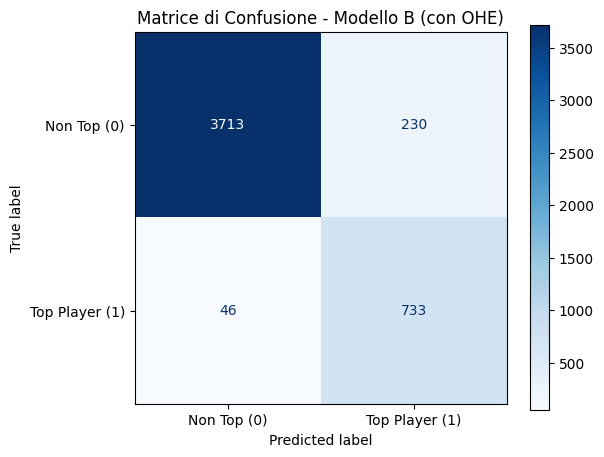

In [30]:
# --- 22. VALUTAZIONE MODELLO (Esperimento B) ---

print("Inizio valutazione (Modello B) sul Test Set...")
y_pred_lr_top_B = model_lr_top_B.predict(X_test_B_scaled)

# Accuratezza
accuracy_lr_top_B = accuracy_score(y_test_B, y_pred_lr_top_B)
print(f"\nAccuratezza (Modello B - con OHE): {accuracy_lr_top_B * 100:.2f}%")

# Confronto
print(f"Accuratezza (Modello A - senza OHE): 93.88%") # Inserisci il tuo valore vecchio!
print("\n--- Classification Report (Modello B) ---")
print(classification_report(y_test_B, y_pred_lr_top_B, target_names=['Non Top (0)', 'Top Player (1)']))

# Matrice di Confusione
print("\n--- Matrice di Confusione (Modello B) ---")
# 
cm_B = confusion_matrix(y_test_B, y_pred_lr_top_B, labels=model_lr_top_B.classes_)
fig, ax = plt.subplots(figsize=(6, 5))
disp_B = ConfusionMatrixDisplay(confusion_matrix=cm_B, 
                              display_labels=['Non Top (0)', 'Top Player (1)'])
disp_B.plot(cmap='Blues', ax=ax, xticks_rotation='horizontal')
plt.title("Matrice di Confusione - Modello B (con OHE)")
plt.show()